# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

# Assignment 4

**Submission deadline:** 

**problems 1-2 last lab session before or on Wednesday, 30.11.18**

**problems 3-8 last lab session before or on Wednesday, 7.12.18**


**Points: 11 + 5 bonus points**


## Downloading this notebook

This assignment is an Colab/Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

If you use Colab please make sure to have a GPU runtime (```Runtime -> Change runtime type -> Hardware Accelarater = GPU```)

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Getting to know PyTorch

From now on, we will use [pytorch](https://pytorch.org/) to implement neural networks.

Good introductions are the [60-minute tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [pytorch examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).


Pytorch has a set of modules to build neural networks. However, for simplicity, this assignment will use a custom, simple neural network code.

In [0]:
import numpy as np
import time
import torch
import torch.nn.functional as F


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        
        This is useful for e.g. Dropout.
        """
        
        self.is_training = True
    
    def eval_mode(self):
        """Put layer into evalation mode.
        
        This is useful for e.g. Dropout.
        """
        self.is_training = False
    
    def to_device(self, device):
        """Move this layer's parameters to thie given device (cpu/cuda).
        """        
        
        pass

    
    @property
    def parameters(self):
        return []
    
    def __repr__(self):
        param_s = ', '.join(['%s%s' % (n, tuple(p.size())) 
                                 for (n,p) in self.parameters])
        if not param_s:
            return '  %s with no params' % (self.__class__.__name__)
        else:
            return '  %s with params: %s' % (self.__class__.__name__, param_s)
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = torch.empty(num_in, num_out, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(1, num_out, dtype=torch.float32, requires_grad=True)
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    def forward(self, x):
        # Flattening if input has more than 2 dimensions
        if len(x.size()) > 2:
            return x.view(x.size(0), -1).mm(self.W) + self.b
        return x.mm(self.W) + self.b
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)
    
# p is dropout probability - a node's output gets ignored with p probability
class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
    
    def forward(self, x):
        # No need to divide the output by (1. - self.p), since pytorch function does it for us
        return F.dropout(x, self.p, self.is_training)

class BatchNormLayer(Layer):
    def __init__(self, num_in):
        self.gamma = torch.empty(1, num_in, dtype=torch.float32, requires_grad=True)
        self.beta = torch.empty(1, num_in, dtype=torch.float32, requires_grad=True)
        self.avg_mean = torch.zeros(1, num_in, dtype=torch.float32, requires_grad=False)
        self.avg_var = torch.ones(1, num_in, dtype=torch.float32, requires_grad=False)
        self.momentum = 0.1
        self.epsilon = 1e-7 # For numerical stability
    
    @property
    def parameters(self):
        return [('gamma', self.gamma), ('beta', self.beta)]
    
    def forward(self, x):
        if self.is_training:
            x_mean = x.mean(dim=0, keepdim=True)
            x_var = ((x - x_mean)**2).mean(dim=0, keepdim=True)
            
            self.avg_mean = (1. - self.momentum) * self.avg_mean + self.momentum * x_mean
            self.avg_var = (1. - self.momentum) * self.avg_var + self.momentum * x_var

            return self.gamma * ((x - x_mean) / (x_var + self.epsilon).sqrt()) + self.beta
        else:
            return self.gamma * ((x - self.avg_mean) / (self.avg_var + self.epsilon).sqrt()) + self.beta
    
    def to_device(self, device):
        with torch.no_grad():
            self.gamma = self.gamma.to(device).requires_grad_()
            self.beta = self.beta.to(device).requires_grad_()
            self.avg_mean = self.avg_mean.to(device).requires_grad_(False)
            self.avg_var = self.avg_var.to(device).requires_grad_(False)

class MaxPoolLayer(Layer):
    def __init__(self, kernel_size, stride=None, padding=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
    def forward(self, x):
        return F.max_pool2d(x, self.kernel_size, stride=self.stride, padding=self.padding)

class ConvLayer(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        if type(kernel_size) is tuple or type(kernel_size) is list:
            kernel_h = kernel_size[0]
            kernel_w = kernel_size[1]
        else:
            kernel_h = kernel_size
            kernel_w = kernel_size
            
        self.W = torch.empty(out_channels, in_channels, kernel_h, kernel_w, dtype=torch.float32, requires_grad=True)
        self.b = torch.empty(out_channels, dtype=torch.float32, requires_grad=True)
    
    @property
    def parameters(self):
        return [('W', self.W), ('b', self.b)]
    
    def forward(self, x):
        return F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
    
    def to_device(self, device):
        with torch.no_grad():
            self.W = self.W.to(device).requires_grad_()
            self.b = self.b.to(device).requires_grad_()


class SoftMaxLayer(Layer):
    def forward(self, x):
        #print("Softmax:", x)
        return F.softmax(x, dim=-1)

class CrossEntropyLoss:
    def forward(self, probs, targets):
        #print("Loss function:", probs)
        return torch.mean(-torch.log(torch.gather(
            probs, 1, targets.unsqueeze(1))))

In [0]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for (_, ownP), newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def to_device(self, device):
        for layer in self.layers:
            layer.to_device(device)
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return self.loss_fn.forward(outputs, targets)
    
    def __repr__(self):
        strs = ["Feedorward network with %d layers:" % (len(self.layers),)]
        for layer in self.layers:
            strs.append(repr(layer))
        return '\n'.join(strs)
            

In [0]:
from sklearn import datasets

iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

IrisX = torch.from_numpy(IrisX)
IrisY = torch.from_numpy(IrisY)

In [0]:
def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6, device='cpu'):
    """Simple batch gradient descent"""
    x = x.to(device)
    y = y.to(device)
    model.to_device(device)
    try:
        old_loss = np.inf
        model.train_mode()
        tstart = time.time()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            
            # this disables autograd mechanism and allows us to 
            with torch.torch.no_grad():
                for _, p in model.parameters:
                    p -= p.grad * alpha
                    # Zero gradients for the next iteration
                    p.grad.zero_()

            loss = loss.item()
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}% | steps/s {3: >5.2f}" \
                      .format(i, loss, err_rate, (1000 if i else 1) / (time.time() - tstart))
                tstart = time.time()
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [0]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])


# Initialize parameters
with torch.torch.no_grad():
    for n, p in model.parameters:
        if n == 'W':
            # p.data.normal_(0, 0.05)
            p.uniform_(-0.1, 0.1)
        elif n == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
# Iris is so small, that trainingon CPU is faster!
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7, device='cpu')

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration      0 | loss  1.10 | err rate  70.00% | steps/s 32.64
Iteration   1000 | loss  0.06 | err rate   2.00% | steps/s 1663.63
Iteration   2000 | loss  0.04 | err rate   2.00% | steps/s 1705.56
Iteration   3000 | loss  0.04 | err rate   1.00% | steps/s 1680.51
Iteration   4000 | loss  0.04 | err rate   1.00% | steps/s 1746.42
Iteration   5000 | loss  0.04 | err rate   1.00% | steps/s 1752.26
Iteration   6000 | loss  0.04 | err rate   1.00% | steps/s 1744.53
Iteration   7000 | loss  0.04 | err rate   1.00% | steps/s 1739.66
Iteration   8000 | loss  0.04 | err rate   1.00% | steps/s 1744.28
Iteration   9000 | loss  0.04 | err rate   1.00% | steps/s 1736.98
Iteration  10000 | loss  0.04 | err rate   1.00% | steps/s 1740.21
Iteration  11000 | loss  0.04 | err rate   1.00% | steps/s 1771.85
Iteration  12000 | loss  0.04 | err rate   1.00% | steps/s 1743.01
Iteration  13000 | loss  0.04 | err rate   1.00% | steps/s 1761.85
Iteration  14000 | loss  0.04 | err rate   1.00% | steps/s 1753.

# Starter code for MNIST and SGD scaffolding

In [0]:
import os
import torch
import torchvision


batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided below (in task 2):
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


In [0]:
def compute_error_rate(model, data_loader, device='cpu', flatten_dimensions=True):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            if flatten_dimensions:
                x = x.view(x.size(0), -1)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, num_epochs=1, patience_expansion=1.5, max_epochs=1e9,
        log_every=100, device='cpu', flatten_dimensions=True, quiet_mode=False, stop_on_nan=False, use_polyak_averaging=False,
        weight_decay=1e-4, polyak_alpha=0.9, learning_rate_schedule=lambda alpha0, iter_, epoch: alpha0, momentum_epsilon_schedule=lambda iter_, epoch: 0.95):
    model.to_device(device)
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    #
    velocities = [torch.zeros_like(p) for (name, p) in model.parameters]
    #
    
    # Remembering alpha0 for learning rate schedules
    alpha0 = alpha
    
    # Creating variables for polyak averaging
    polyak_averages = [torch.zeros_like(p) for (name, p) in model.parameters]
    
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    if not quiet_mode:
        print('Training the model!')
        print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs and epoch < max_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                x = x.to(device)
                y = y.to(device)
                if flatten_dimensions:
                    x = x.view(x.size(0), -1)
                
                iter_ += 1
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                err_rate = 100.0 * (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(err_rate)
                
                if stop_on_nan and loss.item() == float('nan'):
                    print "Loss is nan, bailing out"
                    return

                #if loss.item() == float('inf'):
                    #print "Iteration {0: >6}, loss {1: >5.2f}\n".format(iter_, loss.item())
                #print "Iteration {0: >6}, loss {1: >5.2f}\n".format(iter_, loss.item())
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v, pol in zip(model.parameters, velocities, polyak_averages): 
                        
                        #print("Grad norm:", p.grad.norm(), "Velocity norm:", v.norm())
                        
                        if name == 'W':
                            #pass
                            #
                            # TODO: Implement weight decay addition to gradients
                            #print("Before W decay", name, torch.min(p.grad), torch.max(p.grad))
                            p.grad += weight_decay * p.data
                            # 

                        #
                        # TODO: Update learning rate
                        # Hint: Use the iteration counter i
                        alpha = learning_rate_schedule(alpha0, iter_, epoch)
                        #

                        #
                        # TODO: Set the momentum constant 
                        epsilon = momentum_epsilon_schedule(iter_, epoch)
                        #

                        #
                        # TODO: Implement velocity update in momentum
                        # lease make sure to modify the contents of v, not the v pointer!!!
                        v[...] = epsilon * v - alpha * p.grad
                        #

                        #print("Grad norm:", p.grad.norm(), "Velocity norm:", v.norm(), "Epsilon:", epsilon, "Alpha:", alpha)
                        
                        #
                        # TODO: Set a more sensible learning rule here,
                        #       using your learning rate schedule and momentum
                        # 
                        #p -= alpha * p.grad
                        p += v
                        
                        pol[...] = polyak_alpha * pol + (1. - polyak_alpha) * p
                        
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    if not quiet_mode:
                        print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), err_rate, num_iter / (time.time() - tstart))
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device, flatten_dimensions)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for (_, p) in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            #if not quiet_mode:
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)
            if val_err_rate > 10. and epoch > 1:
                print "The model is bad, bailing out"
                return

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        if not quiet_mode:
            print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        if not use_polyak_averaging:
            model.parameters = best_params
        else:
            model.parameters = [p.detach().cpu() for p in polyak_averages]
    if not quiet_mode:
        plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

### 1 x 3000 hidden num layer, $\epsilon = 0.95$

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.47 | err rate 10.94%, steps/s 59.85
Minibatch    200  | loss  0.31 | err rate  8.59%, steps/s 140.77
Minibatch    300  | loss  0.21 | err rate  6.25%, steps/s 167.72
----------------------------------------------------------
After epoch  1 | valid err rate:  6.86% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.08 | err rate  2.34%, steps/s 114.59
Minibatch    500  | loss  0.27 | err rate  8.59%, steps/s 270.40
Minibatch    600  | loss  0.44 | err rate  5.47%, steps/s 326.97
Minibatch    700  | loss  0.25 | err rate  6.25%, steps/s 392.16
----------------------------------------------------------
After epoch  2 | valid err rate:  5.17% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.11 | err rate  3.91%, steps/s 219.61
Minibatch    900  | loss  0.20 | err ra

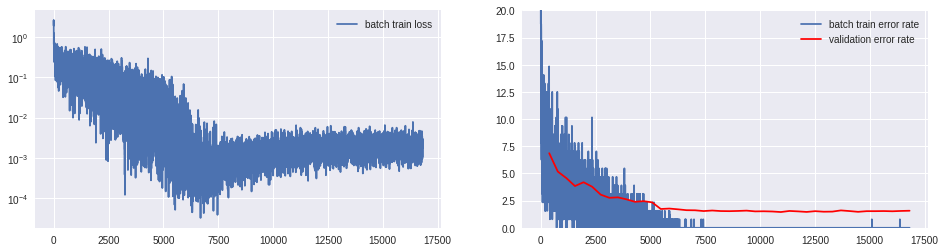

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 3000),
     ReLULayer(),
     AffineLayer(3000, 10),
     SoftMaxLayer()
    ])


# Staircase learning rate schedule - drop learning rate by 0.1 every 1000
#learning_rate_schedule = lambda alpha0, iter_: alpha0 * 0.1**math.floor((iter_ + 1) / 1000) 

# Exponential learning rate schedule - starting with alpha0 and getting half of that after 10000 iterations
learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 

momentum_epsilon_schedule = lambda iter_, epoch: 0.95


with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            # p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
            p.data.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

### 1 x 3000 hidden num layer, $\epsilon = 0.95 - \frac{3}{5 + iteration}$

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.28 | err rate 10.94%, steps/s 49.45
Minibatch    200  | loss  0.16 | err rate  3.12%, steps/s 90.94
Minibatch    300  | loss  0.20 | err rate  6.25%, steps/s 136.37
----------------------------------------------------------
After epoch  1 | valid err rate:  5.02% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.15 | err rate  4.69%, steps/s 96.87
Minibatch    500  | loss  0.28 | err rate  7.81%, steps/s 216.80
Minibatch    600  | loss  0.13 | err rate  4.69%, steps/s 274.78
Minibatch    700  | loss  0.13 | err rate  3.12%, steps/s 321.44
----------------------------------------------------------
After epoch  2 | valid err rate:  4.08% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.10 | err rate  3.91%, steps/s 191.74
Minibatch    900  | loss  0.02 | err rate

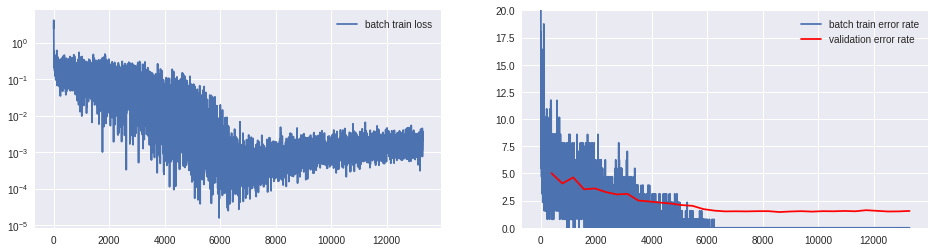

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 3000),
     ReLULayer(),
     AffineLayer(3000, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + iter_)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            # p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
            p.data.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

### 2 layers, $\epsilon = 0.95$

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.19 | err rate  5.47%, steps/s 33.59
Minibatch    200  | loss  0.21 | err rate  8.59%, steps/s 82.82
Minibatch    300  | loss  0.13 | err rate  3.91%, steps/s 125.01
----------------------------------------------------------
After epoch  1 | valid err rate:  4.17% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.19 | err rate  3.91%, steps/s 89.09
Minibatch    500  | loss  0.05 | err rate  1.56%, steps/s 206.61
Minibatch    600  | loss  0.17 | err rate  3.12%, steps/s 250.90
Minibatch    700  | loss  0.09 | err rate  3.12%, steps/s 288.15
----------------------------------------------------------
After epoch  2 | valid err rate:  3.44% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.07 | err rate  2.34%, steps/s 175.55
Minibatch    900  | loss  0.11 | err rate

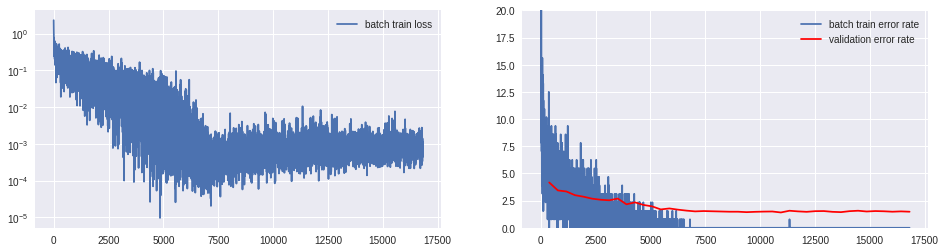

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 2000),
     ReLULayer(),
     AffineLayer(2000, 1000),
     ReLULayer(),
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
#momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + iter_)
momentum_epsilon_schedule = lambda iter_, epoch: 0.95

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            # p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
            p.data.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

### 3 layers

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.17 | err rate  6.25%, steps/s 48.19
Minibatch    200  | loss  0.11 | err rate  3.12%, steps/s 101.81
Minibatch    300  | loss  0.12 | err rate  3.12%, steps/s 151.98
----------------------------------------------------------
After epoch  1 | valid err rate:  3.03% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.07 | err rate  2.34%, steps/s 105.54
Minibatch    500  | loss  0.06 | err rate  2.34%, steps/s 256.37
Minibatch    600  | loss  0.16 | err rate  5.47%, steps/s 302.13
Minibatch    700  | loss  0.03 | err rate  0.78%, steps/s 351.35
----------------------------------------------------------
After epoch  2 | valid err rate:  2.49% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.04 | err rate  0.78%, steps/s 211.98
Minibatch    900  | loss  0.03 | err ra

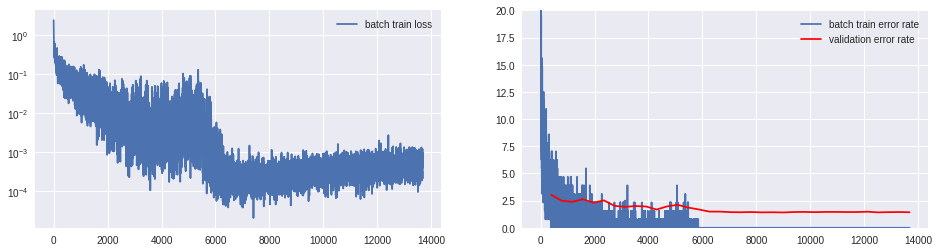

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1200),
     ReLULayer(),
     AffineLayer(1200, 1200),
     ReLULayer(),
     AffineLayer(1200, 1200),
     ReLULayer(),
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + epoch)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.39 | err rate 12.50%, steps/s 50.55
Minibatch    200  | loss  0.30 | err rate  7.81%, steps/s 86.33
Minibatch    300  | loss  0.31 | err rate  8.59%, steps/s 123.65
----------------------------------------------------------
After epoch  1 | valid err rate:  3.74% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.08 | err rate  1.56%, steps/s 86.19
Minibatch    500  | loss  0.18 | err rate  5.47%, steps/s 205.83
Minibatch    600  | loss  0.12 | err rate  3.91%, steps/s 244.33
Minibatch    700  | loss  0.12 | err rate  5.47%, steps/s 285.14
----------------------------------------------------------
After epoch  2 | valid err rate:  2.83% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.19 | err rate  5.47%, steps/s 176.23
Minibatch    900  | loss  0.13 | err rate

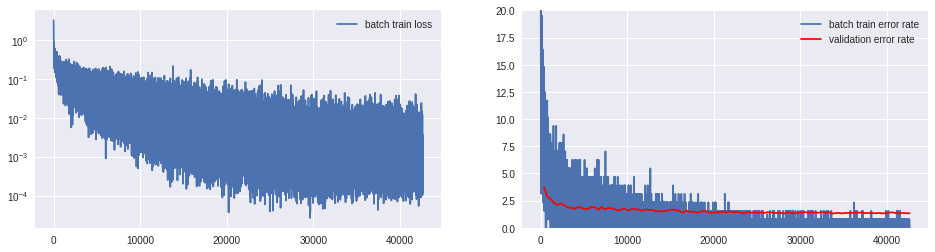

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 1200),
     ReLULayer(),
     DropoutLayer(0.5),
     AffineLayer(1200, 1200),
     ReLULayer(),
     DropoutLayer(0.5),
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + epoch)
#momentum_epsilon_schedule = lambda iter_: 0.5

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            #p.normal_(0, 0.01)
            # p.data.uniform_(-0.1, 0.1)
            p.data.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
            #p.data.uniform_(-np.sqrt(0.001/(p.shape[0] + p.shape[1])), np.sqrt(0.001/(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

Ideas: 
1. Rotation - done
2. Translation - done
3. Gaussian noise - done

In [0]:
class GaussianNoise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, x):
        x += self.mean + self.std * torch.abs(torch.randn_like(x))
        x = torch.clamp(x, min=0., max=1.)
        return x

In [0]:
import os
import torch
import torchvision


batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

augmentation_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=45, translate=(0.1, 0.1)),
        torchvision.transforms.RandomAffine(degrees=45),
        torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        torchvision.transforms.Lambda(lambda x: x)
    ]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomApply([GaussianNoise(0., 0.1)], p=0.5),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])


_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=augmentation_transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True,
        pin_memory=True, num_workers=10),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

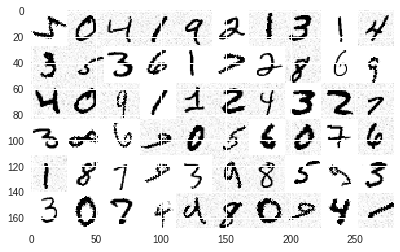

In [0]:
show_cols = 10
show_rows = 6
samples = np.vstack([np.hstack([np.asanyarray(_train[i*show_cols + j][0][0]) for j in range(show_cols)]) for i in range(show_rows)])
plt.imshow(samples)

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.52 | err rate 14.06%, steps/s 30.72
Minibatch    200  | loss  0.46 | err rate 13.28%, steps/s 70.21
Minibatch    300  | loss  0.34 | err rate  7.03%, steps/s 108.50
----------------------------------------------------------
After epoch  1 | valid err rate:  4.90% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.29 | err rate  9.38%, steps/s 86.11
Minibatch    500  | loss  0.33 | err rate  8.59%, steps/s 172.24
Minibatch    600  | loss  0.28 | err rate  7.03%, steps/s 213.83
Minibatch    700  | loss  0.25 | err rate  7.81%, steps/s 250.75
----------------------------------------------------------
After epoch  2 | valid err rate:  2.60% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.14 | err rate  4.69%, steps/s 171.04
Minibatch    900  | loss  0.13 | err rate

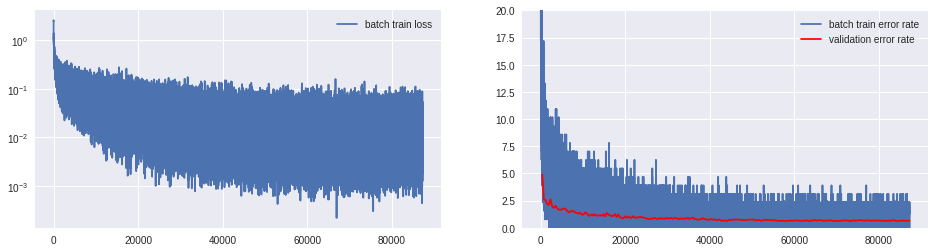

In [0]:
model = FeedforwardNet(
    [
     AffineLayer(784, 1200),
     ReLULayer(),
     #DropoutLayer(0.5),
     AffineLayer(1200, 1200),
     ReLULayer(),
     #DropoutLayer(0.5),
     AffineLayer(1200, 1200),
     ReLULayer(),
     #DropoutLayer(0.5),
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + epoch)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

### 2 layers, $\epsilon = 0.95$

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.36 | err rate  7.03%, steps/s 33.15
Minibatch    200  | loss  0.13 | err rate  3.91%, steps/s 83.56
Minibatch    300  | loss  0.19 | err rate  6.25%, steps/s 127.93
----------------------------------------------------------
After epoch  1 | valid err rate:  2.95% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.07 | err rate  1.56%, steps/s 91.18
Minibatch    500  | loss  0.05 | err rate  1.56%, steps/s 211.60
Minibatch    600  | loss  0.05 | err rate  2.34%, steps/s 252.58
Minibatch    700  | loss  0.06 | err rate  1.56%, steps/s 296.79
----------------------------------------------------------
After epoch  2 | valid err rate:  2.38% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.02 | err rate  0.78%, steps/s 183.01
Minibatch    900  | loss  0.01 | err rate

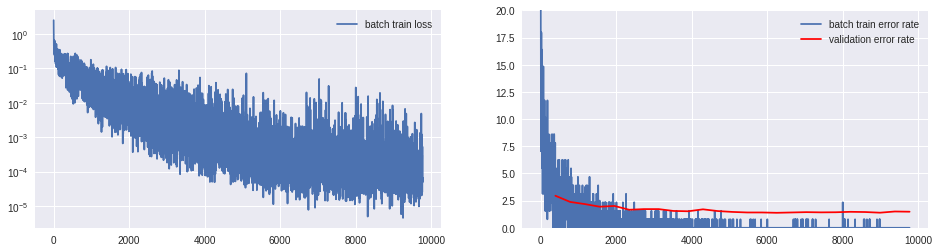

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 2000),
     BatchNormLayer(2000),
     ReLULayer(),
     AffineLayer(2000, 1000),
     BatchNormLayer(1000),
     ReLULayer(),
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
#momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + iter_)
momentum_epsilon_schedule = lambda iter_, epoch: 0.95

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
            #p.normal_(0, 0.01)
        elif name == 'b':
            p.zero_()
        elif name == 'gamma':
            #p.fill_(1.)
            p.uniform_(0,1)
        elif name == 'beta':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=0.)

# After training, the best parameters reside in cpu, but batch norm's average mean and std still remain in cuda
model.to_device('cpu')
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

### 3 layers

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.18 | err rate  5.47%, steps/s 30.48
Minibatch    200  | loss  0.11 | err rate  4.69%, steps/s 74.51
Minibatch    300  | loss  0.15 | err rate  3.91%, steps/s 111.15
----------------------------------------------------------
After epoch  1 | valid err rate:  2.64% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.06 | err rate  0.78%, steps/s 84.81
Minibatch    500  | loss  0.02 | err rate  0.78%, steps/s 185.69
Minibatch    600  | loss  0.06 | err rate  0.78%, steps/s 222.21
Minibatch    700  | loss  0.05 | err rate  1.56%, steps/s 260.01
----------------------------------------------------------
After epoch  2 | valid err rate:  2.11% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.03 | err rate  0.00%, steps/s 168.76
Minibatch    900  | loss  0.05 | err rate

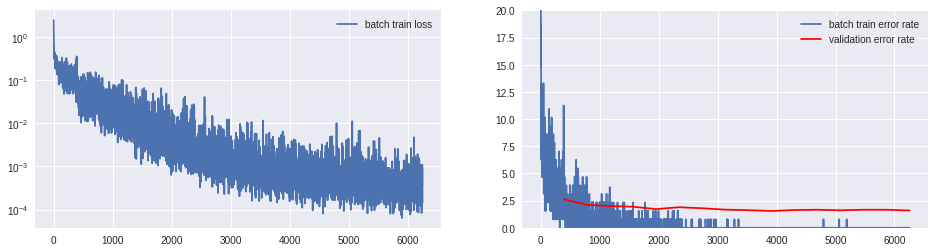

In [0]:
"""
model = FeedforwardNet(
    [
     AffineLayer(784, 1200),
     ReLULayer(),
     BatchNormLayer(1200),
     AffineLayer(1200, 1200),
     ReLULayer(),
     BatchNormLayer(1200),
     AffineLayer(1200, 1200),
     ReLULayer(),
     BatchNormLayer(1200),
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])

"""

model = FeedforwardNet(
    [
     AffineLayer(784, 1200),
     BatchNormLayer(1200),
     ReLULayer(),
     AffineLayer(1200, 1200),
     BatchNormLayer(1200),
     ReLULayer(),
     AffineLayer(1200, 1200),
     BatchNormLayer(1200),
     ReLULayer(),
     AffineLayer(1200, 10),
     SoftMaxLayer()
    ])


#learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_
learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999**epoch
#momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + epoch)
momentum_epsilon_schedule = lambda iter_, epoch: 0.5

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
            #p.normal_(0, 0.01)
        elif name == 'b':
            p.zero_()
        elif name == 'gamma':
            #p.fill_(1.)
            p.uniform_(0,1)
        elif name == 'beta':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=0.)

# After training, the best parameters reside in cpu, but batch norm's average mean and std still remain in cuda
model.to_device('cpu')
print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

### Tuning 3 layer batch norm with hyperparameter optimizer

In [0]:
def print_hyperparam_dict(hyperparam_dict):
    for param in hyperparam_dict:
        print "\t", param, hyperparam_dict[param]
        
def run_network_with_hyperparams(hyperparam_dict):
    data_dim = 784
    num_classes = 10
    
    af_layer1 = hyperparam_dict['af_layer1']
    af_layer2 = hyperparam_dict['af_layer2']
    af_layer3 = hyperparam_dict['af_layer3']
    alpha = hyperparam_dict['lr_alpha0']
    alpha_c = hyperparam_dict['lr_alpha_c']
    momentum_epsilon = hyperparam_dict['momentum_epsilon']
    init_w = hyperparam_dict['init_w']
    weight_decay = hyperparam_dict['weight_decay']
    polyak_alpha = hyperparam_dict['polyak_alpha']
    
    #print af_layer1, af_layer2, alpha, alpha_c, momentum_epsilon, init_w, weight_decay
    
    
    model = FeedforwardNet([
        AffineLayer(data_dim, af_layer1),
        BatchNormLayer(af_layer1),
        ReLULayer(),
        AffineLayer(af_layer1, af_layer2),
        BatchNormLayer(af_layer2),
        ReLULayer(),
        AffineLayer(af_layer2, af_layer3),
        BatchNormLayer(af_layer3),
        ReLULayer(),
        AffineLayer(af_layer3, num_classes),
        SoftMaxLayer()
    ])

    learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * alpha_c**iter_ 
    momentum_epsilon_schedule = lambda iter_, epoch: momentum_epsilon - 3.0/(5.0 + epoch)

    with torch.no_grad():
        # Initialize parameters
        for name, p in model.parameters:
            if name == 'W':
                p.data.uniform_(-np.sqrt(init_w/(p.shape[0] + p.shape[1])), np.sqrt(init_w/(p.shape[0] + p.shape[1])))
            elif name == 'b':
                p.zero_()
            elif name == 'gamma':
                p.uniform_(0,1)
            elif name == 'beta':
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % p.name)

    # On GPU enabled devices set device='cuda' else set device='cpu'
    SGD(model, mnist_loaders, alpha=alpha, device='cuda', max_epochs=50, quiet_mode=True, stop_on_nan=True,
        learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=weight_decay, 
        polyak_alpha=polyak_alpha, use_polyak_averaging=False)

    model.to_device('cpu')
    test_error_rate = compute_error_rate(model, mnist_loaders['test'], device='cpu')
    print "Test error rate: %.2f%%" % test_error_rate
    
    return test_error_rate
    

    
hyperparam_generator = {
    'af_layer1' : lambda: int(np.floor(np.random.uniform(800, 2800))),
    'af_layer2' : lambda: int(np.floor(np.random.uniform(800, 2800))),
    'af_layer3' : lambda: int(np.floor(np.random.uniform(800, 2800))),
    'lr_alpha0' : lambda: float(np.exp(np.random.uniform(np.log(0.01), np.log(0.5)))),
    'lr_alpha_c' : lambda: float(np.random.uniform(0.99995, 0.999999)),
    'momentum_epsilon' : lambda: float(np.random.uniform(0.7, 0.95)),
    'init_w' : lambda: float(np.exp(np.random.uniform(np.log(0.001), np.log(0.5)))),
    'weight_decay' : lambda: 0.,
    'polyak_alpha' : lambda: 995.,
}

optimization_runs = 50
best_hyperparams = None
best_error_rate = 100.

for i in range(optimization_runs):
    hyperp_dict = {param : hyperparam_generator[param]() for param in hyperparam_generator}
    print "Hyperparameter set %d" % i
    print_hyperparam_dict(hyperp_dict)
    test_error_rate = run_network_with_hyperparams(hyperp_dict)
    print "Hyperparameter set %d, test error rate %.2f%%:" % (i, test_error_rate)
    
    
    if test_error_rate < best_error_rate:
        best_hyperparams = hyperp_dict
        best_error_rate = test_error_rate
        
print "Best hyperparameter set - test error rate %.2f%%:" % best_error_rate
print_hyperparam_dict(best_hyperparams)

        
   
        

Hyperparameter set 0
	lr_alpha0 0.0105079174204
	af_layer3 2579
	lr_alpha_c 0.999996514142
	init_w 0.0481378819565
	momentum_epsilon 0.949834555307
	weight_decay 0.0
	af_layer1 2569
	af_layer2 2403
	polyak_alpha 995.0
----------------------------------------------------------
After epoch  1 | valid err rate:  2.59% | doing   2 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate:  2.30% | doing   4 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  3 | valid err rate:  2.10% | doing   5 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  4 | valid err rate:  2.19% | doing   5 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  5 

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.26 | err rate 10.16%, steps/s 34.24
Minibatch    200  | loss  0.26 | err rate  4.69%, steps/s 88.81
Minibatch    300  | loss  0.09 | err rate  1.56%, steps/s 133.62
----------------------------------------------------------
After epoch  1 | valid err rate:  4.09% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.17 | err rate  3.12%, steps/s 97.74
Minibatch    500  | loss  0.26 | err rate  6.25%, steps/s 223.99
Minibatch    600  | loss  0.11 | err rate  3.91%, steps/s 271.10
Minibatch    700  | loss  0.15 | err rate  4.69%, steps/s 311.60
----------------------------------------------------------
After epoch  2 | valid err rate:  3.76% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.06 | err rate  2.34%, steps/s 187.43
Minibatch    900  | loss  0.02 | err rate

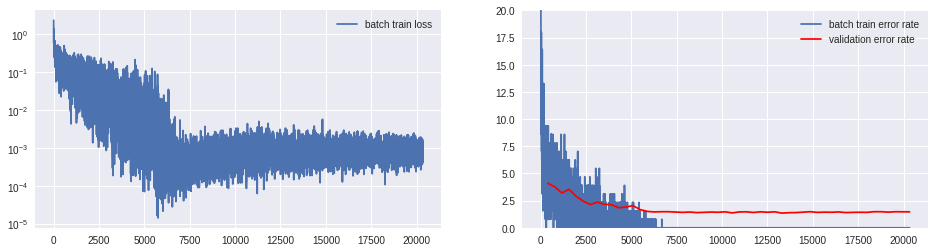

In [0]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

model = FeedforwardNet(
    [
     AffineLayer(784, 2000),
     ReLULayer(),
     AffineLayer(2000, 1000),
     ReLULayer(),
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])

polyak_alpha = 0.995
learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**iter_ 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            p.data.uniform_(-np.sqrt(6./(p.shape[0] + p.shape[1])), np.sqrt(6./(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=1e-1, device='cuda', polyak_alpha=polyak_alpha, use_polyak_averaging=True,
    learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.

43
106
3146
Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.40 | err rate  7.03%, steps/s 27.89
Minibatch    200  | loss  0.31 | err rate  6.25%, steps/s 87.48
Minibatch    300  | loss  0.27 | err rate  8.59%, steps/s 126.60
----------------------------------------------------------
After epoch  1 | valid err rate:  3.15% | doing  50 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.12 | err rate  4.69%, steps/s 88.45
Minibatch    500  | loss  0.05 | err rate  0.78%, steps/s 228.72
Minibatch    600  | loss  0.07 | err rate  3.12%, steps/s 270.81
Minibatch    700  | loss  0.09 | err rate  2.34%, steps/s 320.32
----------------------------------------------------------
After epoch  2 | valid err rate:  2.13% | doing  50 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.05 | err rate  1.56%, steps/s 182.05
Minibatch    900  | loss  0.0

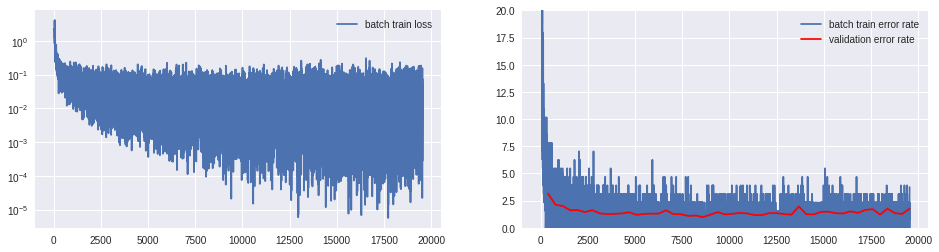

In [0]:
"""
model = FeedforwardNet([
    # We start with 1 x 28 x 28
    ConvLayer(1, 32, 5, padding=2),
    ReLULayer(),
    # Now we have 32 x 28 x 28
    ConvLayer(32, 32, 5, padding=2),
    ReLULayer(),
    # Now we have 32 x 28 x 28
    MaxPoolLayer(2),
    
    # We start with 32 x 14 x 14
    ConvLayer(32, 64, 5, padding=2),
    ReLULayer(),
    # Now we have 64 x 14 x 14
    ConvLayer(64, 64, 5, padding=2),
    ReLULayer(),
    # Now we have 64 x 14 x 14
    MaxPoolLayer(2),
    
    # We start with 64 x 7 x 7
    ConvLayer(64, 128, 3, padding=0),
    ReLULayer(),
    # Now we have 128 x 5 x 5
    ConvLayer(128, 128, 3, padding=1),
    ReLULayer(),
    
    # We start with 128 x 5 x 5
    AffineLayer(128 * 5 * 5, 10),
    SoftMaxLayer()
])
"""

model = FeedforwardNet([
    # We start with 1 x 28 x 28
    ConvLayer(1, 32, 5, padding=2),
    ReLULayer(),
    MaxPoolLayer(2),
    # Now we have 32 x 14 x 14
    ConvLayer(32, 64, 5, padding=2),
    ReLULayer(),
    MaxPoolLayer(2),
    # Now we have 64 x 7 x 7
    AffineLayer(64 * 7 * 7, 10),
    SoftMaxLayer()
])

"""
model = FeedforwardNet([
    # We start with 1 x 28 x 28
    ConvLayer(1, 32, 5, padding=2),
    ReLULayer(),
    MaxPoolLayer(2),
    AffineLayer(32 * 14 * 14, 10),
    SoftMaxLayer()
])
"""

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * 0.999931**epoch 
momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + epoch)

alpha = 0.1
weight_decay = 1e-4

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            total_ns = np.sum(p.shape)
            p.data.uniform_(-np.sqrt(0.005/ total_ns), np.sqrt(0.005/ total_ns))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
# Specifying flatten_dimensions=False so that we can use images (1, 28, 28) instead of 1D inputs (1*28*28)
SGD(model, mnist_loaders, alpha=alpha, device='cuda', flatten_dimensions=False, log_every=100, num_epochs=50,
    learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=weight_decay)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'], flatten_dimensions=False)

# Problem 8: Hyperparameter tuner [1p bonus]

Implement a hyper-parameter tuner able to optimize the learing rate schedule, number of neurons and similar hyperparameters. For start, use random search (please see http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf and especially Fig 1. for intuitions on why random search is better than grid search). It may be a good idea to use a fixed maximum number of epochs (or training time) for each optimization trial to prevent selecting hyperparameters that yield slowly converging solutions. A good result will be a set of hyperparameters that reach on MNIST solutions with test errors less than $1.3\%$ in no more than 50 epochs.

### Tuning 3 layer network

In [0]:
def print_hyperparam_dict(hyperparam_dict):
    for param in hyperparam_dict:
        print "\t", param, hyperparam_dict[param]
        
def run_network_with_hyperparams(hyperparam_dict):
    data_dim = 784
    num_classes = 10
    
    af_layer1 = hyperparam_dict['af_layer1']
    af_layer2 = hyperparam_dict['af_layer2']
    af_layer3 = hyperparam_dict['af_layer3']
    alpha = hyperparam_dict['lr_alpha0']
    alpha_c = hyperparam_dict['lr_alpha_c']
    momentum_epsilon = hyperparam_dict['momentum_epsilon']
    init_w = hyperparam_dict['init_w']
    weight_decay = hyperparam_dict['weight_decay']
    polyak_alpha = hyperparam_dict['polyak_alpha']
    
    #print af_layer1, af_layer2, alpha, alpha_c, momentum_epsilon, init_w, weight_decay
    
    
    model = FeedforwardNet([
        AffineLayer(data_dim, af_layer1),
        ReLULayer(),
        AffineLayer(af_layer1, af_layer2),
        ReLULayer(),
        AffineLayer(af_layer2, af_layer3),
        ReLULayer(),
        AffineLayer(af_layer3, num_classes),
        SoftMaxLayer()
    ])

    learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * alpha_c**iter_ 
    #momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + iter_)
    momentum_epsilon_schedule = lambda iter_, epoch: momentum_epsilon

    with torch.no_grad():
        # Initialize parameters
        for name, p in model.parameters:
            if name == 'W':
                # p.normal_(0, 0.05)
                # p.data.uniform_(-0.1, 0.1)
                p.data.uniform_(-np.sqrt(init_w/(p.shape[0] + p.shape[1])), np.sqrt(init_w/(p.shape[0] + p.shape[1])))
            elif name == 'b':
                p.zero_()
            else:
                raise ValueError('Unknown parameter name "%s"' % p.name)

    # On GPU enabled devices set device='cuda' else set device='cpu'
    SGD(model, mnist_loaders, alpha=alpha, device='cuda', max_epochs=50, quiet_mode=True, stop_on_nan=True,
        learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=weight_decay, 
        polyak_alpha=polyak_alpha, use_polyak_averaging=True)

    model.to_device('cpu')
    test_error_rate = compute_error_rate(model, mnist_loaders['test'], device='cpu')
    print "Test error rate: %.2f%%" % test_error_rate
    
    return test_error_rate
    

    
hyperparam_generator = {
    'af_layer1' : lambda: int(np.floor(np.random.uniform(800, 3500))),
    'af_layer2' : lambda: int(np.floor(np.random.uniform(800, 3500))),
    'af_layer3' : lambda: int(np.floor(np.random.uniform(800, 3500))),
    'lr_alpha0' : lambda: float(np.exp(np.random.uniform(np.log(0.01), np.log(0.5)))),
    'lr_alpha_c' : lambda: float(np.random.uniform(0.99995, 0.999999)),
    'momentum_epsilon' : lambda: float(np.random.uniform(0.7, 0.95)),
    'init_w' : lambda: float(np.exp(np.random.uniform(np.log(0.001), np.log(6)))),
    'weight_decay' : lambda: float(np.exp(np.random.uniform(np.log(5e-7), np.log(5e-4)))),
    'polyak_alpha' : lambda: float(np.exp(np.random.uniform(np.log(0.995), np.log(0.999)))),
}

optimization_runs = 50
best_hyperparams = None
best_error_rate = 100.

for i in range(optimization_runs):
    hyperp_dict = {param : hyperparam_generator[param]() for param in hyperparam_generator}
    print "Hyperparameter set %d" % i
    print_hyperparam_dict(hyperp_dict)
    test_error_rate = run_network_with_hyperparams(hyperp_dict)
    print "Hyperparameter set %d, test error rate %.2f%%:" % (i, test_error_rate)
    
    
    if test_error_rate < best_error_rate:
        best_hyperparams = hyperp_dict
        best_error_rate = test_error_rate
        
print "Best hyperparameter set - test error rate %.2f%%:" % best_error_rate
print_hyperparam_dict(best_hyperparams)

        
   
        

Hyperparameter set 0
	lr_alpha0 0.0105981310959
	af_layer3 3023
	lr_alpha_c 0.999959588646
	init_w 0.00403723546187
	momentum_epsilon 0.751343148839
	weight_decay 3.59687760375e-05
	af_layer1 2768
	af_layer2 2876
	polyak_alpha 0.998178188532
----------------------------------------------------------
After epoch  1 | valid err rate: 89.36% | doing   2 epochs
----------------------------------------------------------
----------------------------------------------------------
After epoch  2 | valid err rate: 89.36% | doing   2 epochs
----------------------------------------------------------
The model is bad, bailing out
Test error rate: 88.65%
Hyperparameter set 0, test error rate 88.65%:
Hyperparameter set 1
	lr_alpha0 0.486261545774
	af_layer3 1097
	lr_alpha_c 0.99999376571
	init_w 2.67061415016
	momentum_epsilon 0.728596488859
	weight_decay 0.000249356347507
	af_layer1 3067
	af_layer2 2557
	polyak_alpha 0.997123180934
----------------------------------------------------------
After ep

TypeError: ignored

In [0]:
best_hyperparam_dict = {
    'lr_alpha0' : 0.10293453811,
    'lr_alpha_c' : 0.999988199362,
    'init_w' : 0.0292658475261,
    'momentum_epsilon' : 0.895760051725,
    'weight_decay' : 9.57249895181e-05,
    'af_layer1' : 3423,
    'af_layer2' : 1932,
    'af_layer3' : 2862,
    'polyak_alpha' : 0.998249230185,
}

Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  2.30 | err rate 90.62%, steps/s 28.51
Minibatch    200  | loss  1.71 | err rate 67.19%, steps/s 68.49
Minibatch    300  | loss  0.36 | err rate 12.50%, steps/s 103.56
----------------------------------------------------------
After epoch  1 | valid err rate:  6.00% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.29 | err rate  7.81%, steps/s 74.94
Minibatch    500  | loss  0.14 | err rate  4.69%, steps/s 170.61
Minibatch    600  | loss  0.15 | err rate  3.91%, steps/s 210.18
Minibatch    700  | loss  0.08 | err rate  3.12%, steps/s 245.37
----------------------------------------------------------
After epoch  2 | valid err rate:  3.26% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.11 | err rate  2.34%, steps/s 146.98
Minibatch    900  | loss  0.09 | err rate

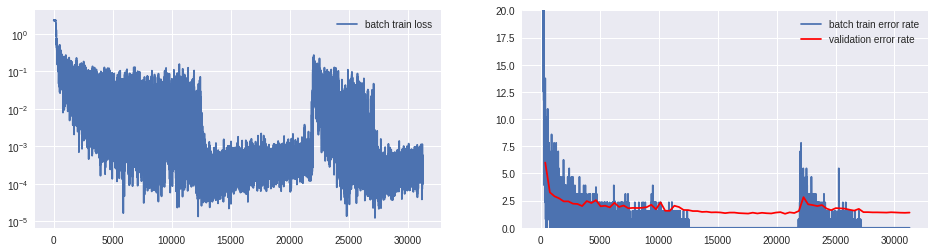

In [0]:
data_dim = 784
num_classes = 10

af_layer1 = best_hyperparam_dict['af_layer1']
af_layer2 = best_hyperparam_dict['af_layer2']
af_layer3 = best_hyperparam_dict['af_layer3']
alpha = best_hyperparam_dict['lr_alpha0']
alpha_c = best_hyperparam_dict['lr_alpha_c']
momentum_epsilon = best_hyperparam_dict['momentum_epsilon']
init_w = best_hyperparam_dict['init_w']
weight_decay = best_hyperparam_dict['weight_decay']
polyak_alpha = best_hyperparam_dict['polyak_alpha']


model = FeedforwardNet([
    AffineLayer(data_dim, af_layer1),
    ReLULayer(),
    AffineLayer(af_layer1, af_layer2),
    ReLULayer(),
    AffineLayer(af_layer2, af_layer3),
    ReLULayer(),
    AffineLayer(af_layer3, num_classes),
    SoftMaxLayer()
])

learning_rate_schedule = lambda alpha0, iter_, epoch: alpha0 * alpha_c**iter_ 
#momentum_epsilon_schedule = lambda iter_, epoch: 0.95 - 3.0/(5.0 + iter_)
momentum_epsilon_schedule = lambda iter_, epoch: momentum_epsilon

with torch.no_grad():
    # Initialize parameters
    for name, p in model.parameters:
        if name == 'W':
            # p.normal_(0, 0.05)
            # p.data.uniform_(-0.1, 0.1)
            p.data.uniform_(-np.sqrt(init_w/(p.shape[0] + p.shape[1])), np.sqrt(init_w/(p.shape[0] + p.shape[1])))
        elif name == 'b':
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % p.name)

# On GPU enabled devices set device='cuda' else set device='cpu'
SGD(model, mnist_loaders, alpha=alpha, device='cuda',
    learning_rate_schedule=learning_rate_schedule, momentum_epsilon_schedule=momentum_epsilon_schedule, weight_decay=weight_decay, 
    polyak_alpha=polyak_alpha, use_polyak_averaging=True)

model.to_device('cpu')
test_error_rate = compute_error_rate(model, mnist_loaders['test'], device='cpu')
print "Test error rate: %.2f%%" % test_error_rate


In [0]:
float('nansss')

ValueError: ignored

In [0]:
np.ones(1)

NameError: ignored